$\textbf{Repeat two methods of optimization of GAN: using eq 1 and alternative method for better gradients}$

Чтобы узнать распределение генератора $p_g$ по данным $x$, мы определяем априорные переменные входного шума $p_z(z)$, затем представляем отображение в пространство данных как $G(z; \theta_g)$, где G - дифференцируемая функция с параметрами $\theta_g$. Мы также определяем $D(x; \theta_d)$, который выводит один скаляр. $D(x)$ представляет вероятность того, что $x$ получено из данных, а не из $p_g$. Мы обучаем $D$, чтобы максимизировать вероятность присвоения исправьте метку как для обучающих примеров, так и для образцов из $G$.
Другими словами, $D$ и $G$ играют в следующую минимаксную игру для двух игроков с функцией значений $V (G, D)$:
$$
\large{
\underset{G}{\min} \underset{D}{\max} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]
}
$$
Оптимизация $D$ до завершения во внутреннем цикле обучения требует больших вычислительных затрат, а на конечных наборах данных привела бы к переобучению. Вместо этого в статье предлагается чередовать k шагов оптимизации $D$ и один шаг оптимизации $G$, потому что $D$ будет вблизи своего оптимального решения, пока $G$ изменяется достаточно медленно.
На ранних этапах обучения, когда $G$ является плохим, $D$ может отклонять выборки с высокой степенью достоверности, поскольку они явно отличаются от обучающих данных. Вместо обучения $G$, чтобы минимизировать $\log(1 − D(G(z)))$ мы можем обучить $G$ максимизировать $\log D(G(z))$. Эта целевая функция приводит к одной и той же фиксированной точке динамики G и D, но обеспечивает гораздо более сильные градиенты на ранних этапах обучения.

Вопрос: почему мы минимизируем функцию потерь?

In [1]:
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass

import os
from functools import partial
import jax
import optax
import jax.numpy as jnp
from typing import Any, Tuple
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.nn.initializers import normal as normal_init
from flax.training import train_state
from flax import linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from flax.training.common_utils import shard, shard_prng_key

2023-12-02 23:03:48.420631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
arr = jnp.arange(10)

2023-12-02 23:03:51.187156: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
device = arr.device()
device.platform, device.device_kind

('gpu', 'NVIDIA GeForce RTX 3090')

In [4]:
jax.devices()

[gpu(id=0)]

In [71]:
### функция для отрисовки
def plot_samples_and_losses(gen_loss, disc_loss, sample):
  plt.plot(disc_loss, label='discriminator loss')
  plt.plot(gen_loss, label='generator loss')
  plt.legend()
  fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
  for ax, image in zip(sum(axes.tolist(), []), sample):
    ax.imshow(image, cmap='gray')
    ax.set_axis_off()
  plt.show()

In [72]:
# инициализация гиперпараметров
PRNGKey = jnp.ndarray
#num_devices = jax.device_count()
args = {'z_dim': 64, 'seed': 41}
args['batch_size'] = 256 #num_devices * 256 if num_devices > 1 else 256
args['epochs'] = 21
#args['batch_size_p'] = args['batch_size'] //  num_devices

args['true_label'] = jnp.ones((args['batch_size'], 1), dtype=jnp.int32)
args['false_label'] = jnp.zeros((args['batch_size'], 1), dtype=jnp.int32)

In [73]:
jax.device_count()

1

In [74]:
# подгрузка данных
def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5
  return batch


mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // args['batch_size']

data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=args['seed'])
        .repeat()
        .batch(args['batch_size'])
 ))

## GAN

In [75]:
class TrainState(train_state.TrainState):
  batch_stats: Any
class Generator(nn.Module):
  features: int = 64
  dtype: type = jnp.float32

  @nn.compact
  def __call__(self, z: jnp.ndarray, train: bool = True):
    conv_transpose = partial(nn.ConvTranspose, padding='VALID',
                             kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)

    z = z.reshape((args['batch_size'], 1, 1, args['z_dim']))
    x = conv_transpose(self.features*4, kernel_size=[3, 3], strides=[2, 2])(z)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*3, kernel_size=[4, 4], strides=[1, 1])(x)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*2, kernel_size=[3, 3], strides=[2, 2])(x)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(1, [4, 4], [2, 2])(x)
    x = jnp.tanh(x)
    return x


class Discriminator(nn.Module):
  features: int = 64
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, train: bool = True):
    conv = partial(nn.Conv, kernel_size=[4, 4], strides=[2, 2], padding='VALID',
                   kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)

    x = conv(self.features)(x)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(self.features*2)(x)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(1)(x)
    x = x.reshape((args['batch_size'], -1))
    return x


@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape):
  model = model_cls()

  tx = optax.adam(0.0002, b1=0.5, b2=0.999)
  variables = model.init(rng, jnp.ones(input_shape))

  state = TrainState.create(apply_fn=model.apply, tx=tx,
      params=variables['params'], batch_stats=variables['batch_stats'])
  return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
  generated_data = generator_state.apply_fn(
      {'params': generator_state.params,
       'batch_stats': generator_state.batch_stats},
      input_noise, train=False, mutable=False)
  return generated_data

## Loss Function

In [88]:
@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   key: PRNGKey):

  input_noise = jax.random.normal(key, (args['batch_size'], args['z_dim']))

  def loss_fn_min(params):
    generated_data, mutables = generator_state.apply_fn(
        {'params': params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])

    logits, _ = discriminator_state.apply_fn(
        {'params': discriminator_state.params,
         'batch_stats': discriminator_state.batch_stats},
         generated_data, mutable=['batch_stats'])

    loss = jnp.mean(jnp.log(1 - logits))
    return loss, mutables

  def loss_fn_max(params):
    generated_data, mutables = generator_state.apply_fn(
        {'params': params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])

    logits, _ = discriminator_state.apply_fn(
        {'params': discriminator_state.params,
         'batch_stats': discriminator_state.batch_stats},
         generated_data, mutable=['batch_stats'])
    generated_loss = optax.sigmoid_binary_cross_entropy(
        logits, args['false_label']).mean()

    loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))
    return loss, mutables

  grad_fn = jax.value_and_grad(loss_fn_min, has_aux=True)
  (loss, mutables), grads = grad_fn(generator_state.params)

  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  new_generator_state = generator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])

  return new_generator_state, loss


@partial(jax.pmap, axis_name='num_devices')
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):

  input_noise = jax.random.normal(key, (args['batch_size'], args['z_dim']))

  generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
         input_noise, mutable=['batch_stats'])

  def loss_fn(params):
    logits_real, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': discriminator_state.batch_stats},
        real_data, mutable=['batch_stats'])

    logits_generated, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': mutables['batch_stats']},
        generated_data, mutable=['batch_stats'])

    real_loss = optax.sigmoid_binary_cross_entropy(
        logits_real, args['true_label']).mean()
    generated_loss = optax.sigmoid_binary_cross_entropy(
        logits_generated, args['false_label']).mean()

    loss = (real_loss + generated_loss) / 2

    return loss, mutables

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, mutables), grads = grad_fn(discriminator_state.params)

  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')


  new_discriminator_state = discriminator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])

  return new_discriminator_state, loss

## Training

In [89]:
def main():
  """
  init params
  """
  key = jax.random.PRNGKey(seed=args['seed'])
  key_generator, key_discriminator, key = jax.random.split(key, 3)
  key_generator = shard_prng_key(key_generator)
  key_discriminator = shard_prng_key(key_discriminator)

  discriminator_state = create_state(key_discriminator, Discriminator,
      (args['batch_size'], *next(data_gen).shape[1:]))

  generator_state = create_state(key_generator, Generator,
      (args['batch_size'], args['z_dim']))

  generator_input = jax.random.normal(key, (args['batch_size'], args['z_dim']))
  generator_input = shard(generator_input)
  """
  train model and generate
  """
  disc_loss = []
  gen_loss = []
  for epoch in tqdm(range(1, args['epochs'] + 1), desc="Epoch",
                    position=0, leave=True):

    with tqdm(total=batches_in_epoch, desc="Train model", leave=False) as progress_bar_train:
      for batch in range(batches_in_epoch):
        key, key_generator, key_discriminator = jax.random.split(key, 3)
        key_generator = shard_prng_key(key_generator)
        key_discriminator = shard_prng_key(key_discriminator)
        batch_data = shard(next(data_gen))
        generator_state, generator_loss = generator_step(generator_state,
            discriminator_state, key_generator)
        discriminator_state, discriminator_loss = discriminator_step(
            generator_state, discriminator_state, batch_data, key_discriminator)

        progress_bar_train.update(1)

        disc_loss.append(discriminator_loss)
        gen_loss.append(generator_loss)

  sample = sample_from_generator(generator_state, generator_input)
  sample = sample.reshape((-1, 28, 28))
  return gen_loss, disc_loss, sample

$\textbf{Стандартный способ тренировки генератора G}$

In [78]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

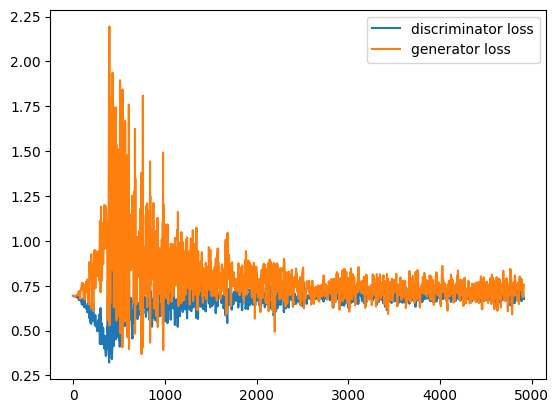

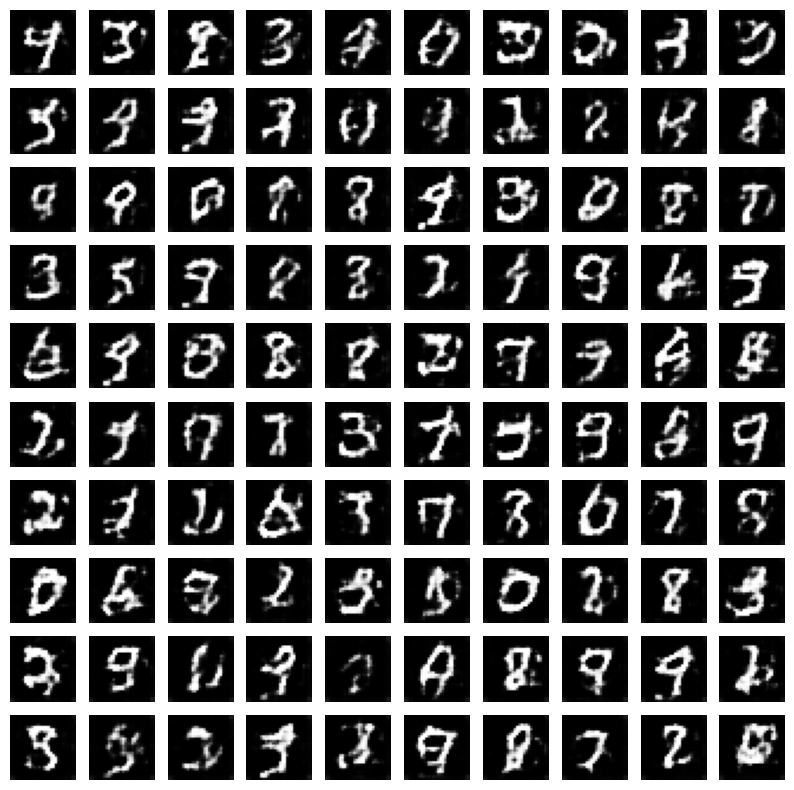

In [79]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

$\textbf{Алтернативный способ тренировки генератора G}$

In [ ]:
# нужно перезапусть ячейки, начиная с определения лоссов, поставив в лоссе генератора функцию loss_fn_min, бинарная перекрестная потеря энтропии без отрицательного знака в начале

In [90]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/21 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

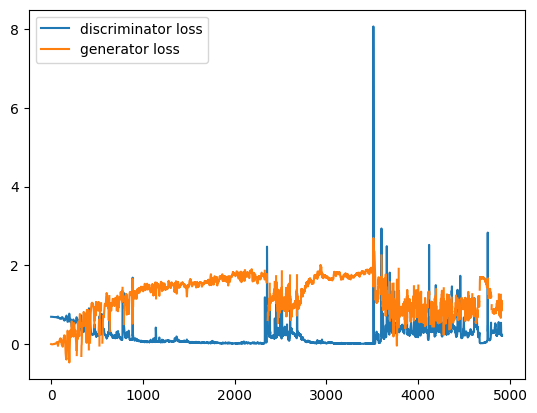

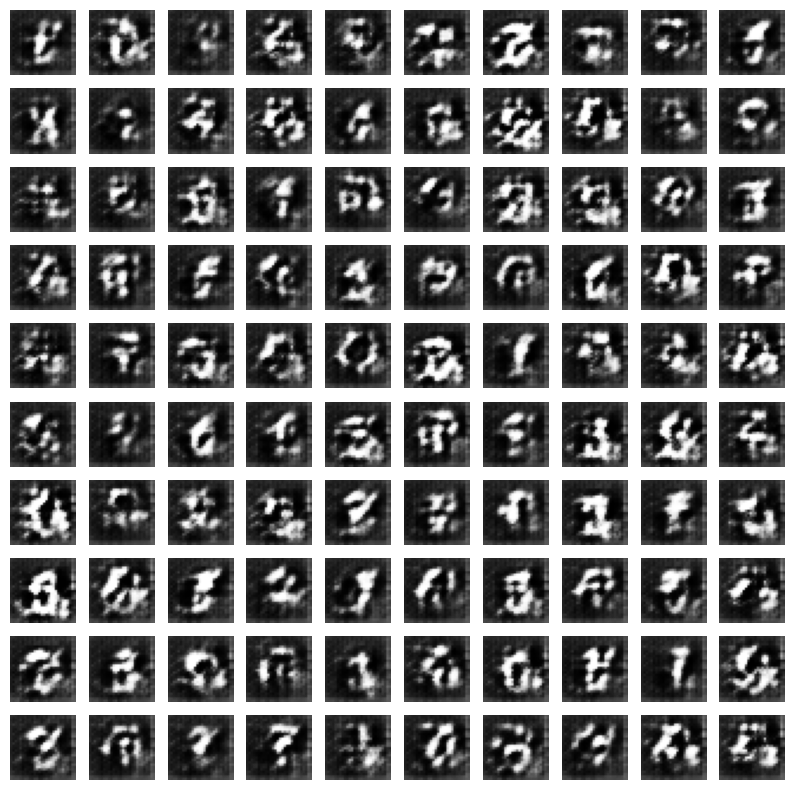

In [91]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

In [ ]:
# давайте обучим больше эпох

In [92]:
args['epochs'] = 40

In [93]:
gen_loss, disc_loss, sample = main()

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

Train model:   0%|          | 0/234 [00:00<?, ?it/s]

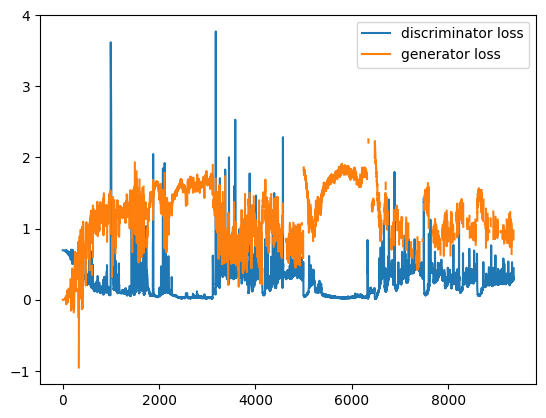

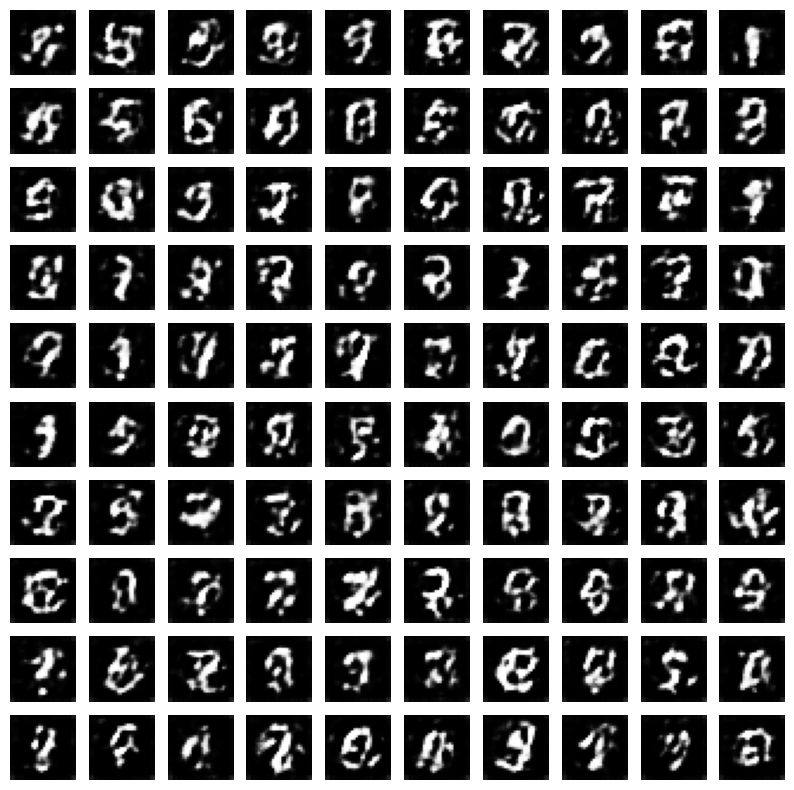

In [94]:
plot_samples_and_losses(gen_loss, disc_loss, sample)

Можно заметить, что во втором случае качество генерации получилось намного хуже, почти невозможно отличить числа на картинке и видим явный мод коллпас. Конечно, сходимости нашего подхода тоже сложно заметить.

Поэтому я решила попробовать обучить большее количество жпох, наблюдаем, что картинки стали намного лучше, конечно, еще не такие как в первом случае. Но с лоссами еще беда..

Поэтому вывод сходимость мы наблюдаем в первом случае и лучшую генерацию тоже, тогда обоснование применения именно такого обучения присутствует:)